# P, PD and PID Controller Comparison for IIWA14

**Learning Objectives:**
1. Understand the limitations of P (Proportional) controllers
2. Learn how PD (Proportional-Derivative) control improves system performance
3. Improve the PD controller by building a PID (Proportional, Inetgral & Derivative) controller  
4. Compare their performance through simulation and visualization

**Your TODOs:**
1. Understand limitations of P controller, by changing the gain, K_p
2. Implement PD controller for the IIWA14 robot
3. Implement PID controllers for the IIWA14 robot
4. Compare performace of P, PD & PID controllers!

---

## Setup and Imports

Let's start by importing the necessary Drake components and setting up our visualization.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    BasicVector,
    Context,
    Diagram,
    DiagramBuilder,
    LeafSystem,
    MeshcatVisualizer,
    ModelInstanceIndex,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    VectorLogSink,
)

from manipulation import running_as_notebook

In [2]:
# Start meshcat for visualization (same as 03_physics_simulation)
meshcat = StartMeshcat()
print(f"Meshcat URL: {meshcat.web_url()}")
print("Click the link above to open Meshcat in your browser!")

INFO:drake:Meshcat listening for connections at http://localhost:7005


Meshcat URL: http://localhost:7005
Click the link above to open Meshcat in your browser!


## Part 1: Simple P Controller (from Pset 1)

Let's start by implementing the simple P (Proportional) controller exactly as it you saw back in Pset 1.

**Recap: P Controller Formula:** $\tau = K_p (q_{desired} - q)$

Where:
- $\tau$ = joint torques
- $K_p$ = proportional gain
- $q$ = current joint positions
- $q_{desired}$ = desired joint positions

In [3]:
class SimpleController(LeafSystem):
    """Simple P controller"""

    def __init__(self, gain: float, q_desired: np.ndarray) -> None:
        LeafSystem.__init__(self)
        self.input_port = self.DeclareVectorInputPort("iiwa_state", 14)
        self.output_port = self.DeclareVectorOutputPort(
            "iiwa_torque", 7, self.ComputeTorque
        )
        self.gain = gain
        self.q_desired = q_desired

    def ComputeTorque(self, context: Context, output: BasicVector) -> None:
        iiwa_state = self.input_port.Eval(context)
        q = iiwa_state[:7]
        output.set_value(-self.gain * (q - self.q_desired))

In [4]:
def create_IIWA14_diagram_with_controller(
    controller_gain: float, q_desired: np.ndarray
) -> tuple[Diagram, MultibodyPlant, ModelInstanceIndex, VectorLogSink]:
    """Create a diagram with the IIWA and P controller (same as 03_physics_simulation)"""

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    parser = Parser(plant, scene_graph)

    # Load the IIWA model
    iiwa = parser.AddModelsFromUrl(
        "package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf"
    )[0]

    # Weld the base
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
    plant.Finalize()

    # Create controller
    controller = builder.AddSystem(
        SimpleController(gain=controller_gain, q_desired=q_desired)
    )

    # Add logger for data collection
    logger = builder.AddSystem(VectorLogSink(14))

    # Connect everything
    builder.Connect(plant.get_state_output_port(iiwa), controller.input_port)
    builder.Connect(controller.output_port, plant.get_actuation_input_port(iiwa))
    builder.Connect(plant.get_state_output_port(iiwa), logger.get_input_port())

    # Add visualizer
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    diagram = builder.Build()

    return diagram, plant, iiwa, logger

In [5]:
def simulate_IIWA14_with_controller(
    q0: np.ndarray,
    controller_gain: float,
    q_desired: np.ndarray,
    simulation_time=3.0,
    set_target_realtime_rate=True,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Simulate IIWA14 with P controller (same as 03_physics_simulation)"""

    diagram, plant, iiwa, logger = create_IIWA14_diagram_with_controller(
        controller_gain, q_desired
    )

    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(diagram_context)
    plant.SetPositions(plant_context, q0)

    simulator = Simulator(diagram, diagram_context)
    if set_target_realtime_rate:
        simulator.set_target_realtime_rate(1.0)

    simulator.AdvanceTo(simulation_time)

    # Extract logged data
    log = logger.FindLog(diagram_context)
    times = log.sample_times()
    states = log.data()

    final_positions = plant.GetPositions(plant_context)
    return final_positions, times, states

## Test the P Controller

Test the P controller with different gains to see its behavior. Try with 50, 100, and 500. Feel free to test with more if you'd like :)

In [ ]:
q_initial = np.array([0.5, 0.3, 0, -0.5, 0, 0.8, 0])

# Desired locations is standing upright
q_desired = np.array([0, 0, 0, 0, 0, 0, 0])

# TODO: Try 50, 100, and 500
kp_to_test =  # Gain value here

print("=== Testing P Controller ===")
print(f"Watch the robot in Meshcat: {meshcat.web_url()}")
q_final, times_p, states_p= simulate_IIWA14_with_controller(
    q_initial,
    controller_gain=kp_to_test,
    q_desired=q_desired,
    simulation_time=8.0 if running_as_notebook else 0.1,
    set_target_realtime_rate=running_as_notebook,
)
print(f"Final error: {np.abs(q_final - q_desired)}")

=== Testing P Controller ===
Watch the robot in Meshcat: http://localhost:7005
Final error: [2.96416289e-01 2.01153999e-02 8.79428425e-02 2.56741770e-02
 6.67481824e-03 6.98381970e-02 2.39417035e-04]


## Gradescope Verification

1. For k_p value of 100, which joint has the highest error and what is the error? (enter the error up to four decimal places)
 

## The Problem with P Controllers

As seen in the example, large proportional gains make the arm oscillate or overshoot, while small gains make it too slow and inaccurate. 

## Part 2: Working Towards a better Solution - PD Controller

A **PD (Proportional-Derivative) controller** adds a derivative term that dampens the system and reduces some of the oscilations:

**PD Controller Formula:** $\tau = K_p (q_{desired} - q) + K_d (\dot{q}_{desired} - \dot{q})$

Where:
- $K_d$ = derivative gain
- $\dot{q}$ = current joint velocities  
- $\dot{q}_{desired}$ = desired joint velocities (usually 0 for position control)

**Key Benefits:**
1. **Damping**: The derivative term reduces oscillations
2. **Better stability**: Can use higher proportional gains without oscillation
3. **Faster settling**: System reaches target more quickly and smoothly

In [9]:
class PDController(LeafSystem):
    """PD controller for the IIWA robot"""

    def __init__(self, kp: float, kd: float, q_desired: np.ndarray) -> None:
        LeafSystem.__init__(self)

        self.input_port = self.DeclareVectorInputPort("iiwa_state", 14)
        self.output_port = self.DeclareVectorOutputPort(
            "iiwa_torque", 7, self.ComputeTorque
        )

        self.kp = kp
        self.kd = kd
        self.q_desired = q_desired
        self.qdot_desired = #TODO  

    def ComputeTorque(self, context: Context, output: BasicVector) -> None:
        # Extract state information
        iiwa_state = self.input_port.Eval(context)
        q = iiwa_state[:7]  # Joint positions
        qdot = iiwa_state[7:]  # Joint velocities

        # Compute errors
        position_error = #TODO 
        velocity_error = #TODO

        # PD control law
        torque = #TODO

        output.set_value(torque)

SyntaxError: invalid syntax (2564639656.py, line 15)

In [10]:
def create_IIWA14_diagram_with_pd_controller(
    kp: float, kd: float, q_desired: np.ndarray
) -> tuple[Diagram, MultibodyPlant, ModelInstanceIndex, VectorLogSink]:
    """Create a diagram with the IIWA and PD controller."""

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    parser = Parser(plant, scene_graph)

    # Load the IIWA model (same as P controller)
    iiwa = parser.AddModelsFromUrl(
        "package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf"
    )[0]

    # Weld the base
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
    plant.Finalize()

    # Create PD controller
    controller = builder.AddSystem(PDController(kp=kp, kd=kd, q_desired=q_desired))

    # Add logger for data collection
    logger = builder.AddSystem(VectorLogSink(14))

    # Connect everything (same pattern as P controller)
    builder.Connect(plant.get_state_output_port(iiwa), controller.input_port)
    builder.Connect(controller.output_port, plant.get_actuation_input_port(iiwa))
    builder.Connect(plant.get_state_output_port(iiwa), logger.get_input_port())

    # Add visualizer
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    diagram = builder.Build()

    return diagram, plant, iiwa, logger

In [11]:
def simulate_IIWA14_with_pd_controller(
    kp: float,
    kd: float,
    q_initial: np.ndarray,
    q_desired: np.ndarray,
    simulation_time: float = 8.0,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Simulate IIWA14 with PD controller."""

    diagram, plant, iiwa, logger = create_IIWA14_diagram_with_pd_controller(
        kp, kd, q_desired
    )

    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(diagram_context)
    plant.SetPositions(plant_context, q_initial)

    simulator = Simulator(diagram, diagram_context)
    if running_as_notebook:
        simulator.set_target_realtime_rate(1.0)

    simulator.AdvanceTo(simulation_time)

    # Extract logged data
    log = logger.FindLog(diagram_context)
    times = log.sample_times()
    states = log.data()

    final_positions = plant.GetPositions(plant_context)
    return final_positions, times, states

## Test the PD Controller
We'll set k_p to be 500, which causes a great deal of oscilations with just the p controller. Let's see how adding a derivative component can help dampen the oscilcations. 

Test the PD controller with the same high gain that caused oscillations in the P controller. Test with K_d values of 10, 20, and 50. How does the control differ as K_d varies? 

In [ ]:
q_initial = np.array([0.5, 0.3, 0, -0.5, 0, 0.8, 0])
q_desired = np.array([0, 0, 0, 0, 0, 0, 0])

print("=== Testing PD Controller ===")
print(f"Watch the robot in Meshcat: {meshcat.web_url()}")

#TODO: Try 10, 20, and 50 as kd values
kd_to_test = #Gain value here 


#Recording to allow playback
meshcat.StartRecording()
q_final_pd, times_pd, states_pd = simulate_IIWA14_with_pd_controller(
    kp=150, 
    kd=kd_to_test, 
    q_initial=q_initial,
    q_desired=q_desired,
    simulation_time=8.0 if running_as_notebook else 0.1,
)


meshcat.StopRecording()
meshcat.PublishRecording()

print(f"Final error: {np.abs(q_final_pd - q_desired)}")

=== Testing PD Controller ===
Watch the robot in Meshcat: http://localhost:7005


Final error: [2.41016348e-07 3.15213203e-04 1.55259685e-06 8.12736463e-05
 1.82216381e-06 2.94817574e-06 7.71016290e-11]


## Gradescope Verification

1. For k_d of 50, which joint has the highest error and what is the error of that joint? (enter your error up to 4 decimal places)

## Part 3: The Complete Solution - PID  

While PD controllers solve the oscillation problem, they still have one limitation: **steady-state error**. If there are disturbances, modeling errors, or gravity effects, the system might not reach the exact target position.

A **PID (Proportional-Integral-Derivative) controller** adds an integral term that eliminates steady-state error:

**PID Controller Formula:** $\tau = K_p (q_{desired} - q) + K_d (\dot{q}_{desired} - \dot{q}) + K_i \int (q_{desired} - q) dt$

Where:
- $K_i$ = integral gain
- $\int (q_{desired} - q) dt$ = accumulated position error over time

**Key Benefits of the Integral Term:**
1. **Disturbance Rejection**: Compensates for constant disturbances
2. **Model Uncertainty**: Handles modeling errors and unmodeled dynamics


### Your Task: Implement the PID Controller

Complete the `PIDController` class below by filling in the missing parts:



In [ ]:
class PIDController(LeafSystem):
    """PID controller for the IIWA robot"""

    def __init__(self, kp: float, kd: float, ki: float, q_desired: np.ndarray) -> None:
        LeafSystem.__init__(self)
        
        self.input_port = self.DeclareVectorInputPort("iiwa_state", 14)
        self.output_port = self.DeclareVectorOutputPort("iiwa_torque", 7, self.ComputeTorque)
        
        self.kp = kp
        self.kd = kd
        self.ki = ki  # New: integral gain
        self.q_desired = q_desired
        self.qdot_desired = np.zeros(7)
        self.integral_error = np.zeros(7)
        
        self.prev_time = 0.0

    def ComputeTorque(self, context: Context, output: BasicVector) -> None:
        # TODO: Extract state information (same as PD controller)
        iiwa_state = # YOUR CODE HERE
        q = # YOUR CODE HERE
        qdot = # YOUR CODE HERE 
        
        current_time = context.get_time()
        dt = current_time - self.prev_time
        
        # TODO: Compute position and velocity errors (same as PD controller)
        position_error = # YOUR CODE HERE
        velocity_error = # YOUR CODE HERE
        
        # TODO: Update integral error
        if dt > 0:  # Avoid division by zero on first call
            # YOUR CODE HERE - update self.integral_error
            pass
        
        # TODO: Compute PID control law
        # HINT: Combine all three terms: proportional + derivative + integral
        torque = # YOUR CODE HERE
        
        # Update previous time for next iteration
        self.prev_time = current_time
        
        output.set_value(torque)


SyntaxError: invalid syntax (4022644941.py, line 21)

In [16]:
def create_IIWA14_diagram_with_pid_controller(
    kp: float, kd: float, ki: float, q_desired: np.ndarray
) -> tuple[Diagram, MultibodyPlant, ModelInstanceIndex, VectorLogSink]:
    """Create a diagram with the IIWA and PID controller."""

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    parser = Parser(plant, scene_graph)

    # Load the IIWA model (same as P and PD controllers)
    iiwa = parser.AddModelsFromUrl(
        "package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf"
    )[0]

    # Weld the base
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
    plant.Finalize()

    # Create PID controller (using solution class)
    controller = builder.AddSystem(
        PIDController(kp=kp, kd=kd, ki=ki, q_desired=q_desired)
    )

    # Add logger for data collection
    logger = builder.AddSystem(VectorLogSink(14))

    # Connect everything (same pattern as P and PD controllers)
    builder.Connect(plant.get_state_output_port(iiwa), controller.input_port)
    builder.Connect(controller.output_port, plant.get_actuation_input_port(iiwa))
    builder.Connect(plant.get_state_output_port(iiwa), logger.get_input_port())

    # Add visualizer
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    diagram = builder.Build()

    return diagram, plant, iiwa, logger

In [17]:
def simulate_IIWA14_with_individual_pid_controller(
    kp: float,
    kd: float,
    ki: float,
    q_initial: np.ndarray,
    q_desired: np.ndarray,
    gear_ratios: np.ndarray = np.array([150, 150, 150, 150, 150, 150, 150]),
    simulation_time: float = 8.0,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Simulate IIWA14 with PID controller."""

    diagram, plant, iiwa, logger = create_IIWA14_diagram_with_pid_controller(
        kp, kd, ki, q_desired
    )

    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(diagram_context)

    for joint_idx in range(7):
        joint_actuator = plant.get_joint_actuator(
            plant.GetJointActuatorIndices(iiwa)[joint_idx]
        )
        joint_actuator.SetGearRatio(plant_context, gear_ratios[joint_idx])

    plant.SetPositions(plant_context, q_initial)

    simulator = Simulator(diagram, diagram_context)
    if running_as_notebook:
        simulator.set_target_realtime_rate(1.0)

    simulator.AdvanceTo(simulation_time)

    # Extract logged data
    log = logger.FindLog(diagram_context)
    times = log.sample_times()
    states = log.data()

    final_positions = plant.GetPositions(plant_context)
    return final_positions, times, states

## Test the PID Controller
Test the PID controller with Test k_i values of 1, 2 and 5. 

In [ ]:
print("=== Testing Individual Joint PID Controller ===")
print(f"Watch the robot in Meshcat: {meshcat.web_url()}")
q_initial_individual = np.array([0.8, -0.5, 0.3, -1.2, 0.2, 0.7, -0.3])
q_target_individual = np.array([0, 0, 0, 0, 0, 0, 0])

kp_per_joint = 150
kd_per_joint = 30
# Try 1, 2, and 5
ki_per_joint = #TODO 


meshcat.StartRecording()
q_final_individual, times_individual, states_individual = (
    simulate_IIWA14_with_individual_pid_controller(
        kp=kp_per_joint,
        kd=kd_per_joint,
        ki=ki_per_joint,
        q_initial=q_initial_individual,
        q_desired=q_target_individual,
        simulation_time=8.0 if running_as_notebook else 0.1,
    )
)
meshcat.StopRecording()
meshcat.PublishRecording()

print(f"Final error: {np.abs(q_final_individual - q_target_individual)}")

=== Testing Individual Joint PID Controller ===
Watch the robot in Meshcat: http://localhost:7005


Final error: [0.00421452 0.00290405 0.00174574 0.00789331 0.0011019  0.00382066
 0.00158427]


## Gradescope Verification

1. For k_p of 150, k_d of 30 and k_i of 5, which joint has the highest error and what is the error of that joint? (enter your error up to 4 decimal places)
2. (Optional) Change some of the gains, are you able to reduce the error even more? 

## Comparision: P vs PD vs PID Performance on Joints 2, 3 & 4

Run the code below to visualize the osiclations and differences between the different controllers. 

You may notice that the error between PD & PID is negligible or that PD performs better in some cases. This can happen because the integral term in PID controllers can sometimes introduce **integral windup** - where the accumulated error becomes too large and causes overshoot or slower settling. Additionally, if the system doesn't have significant steady-state disturbances or modeling errors, the integral term may not provide much benefit. 

Running P controller...
Running PD controller...
Running PID controller...


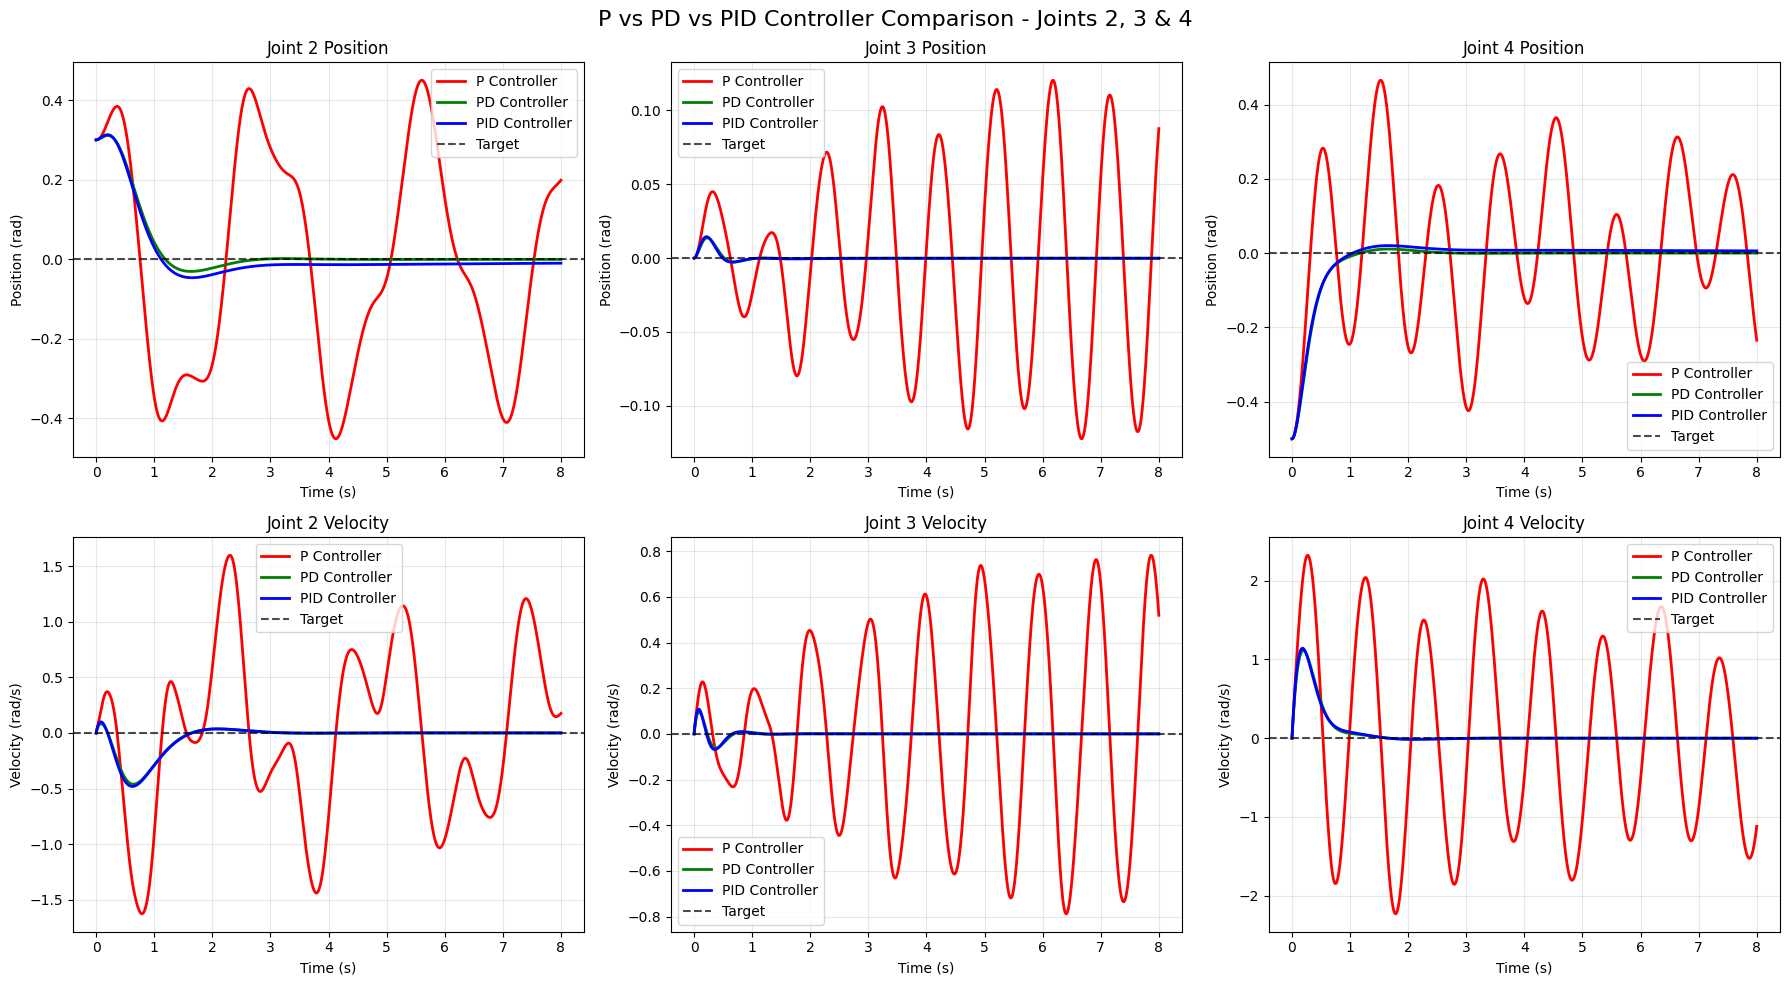


=== Final Position Errors ===
Joint 2 Errors:
  P Controller:   0.1986 rad
  PD Controller:  0.0004 rad
  PID Controller: 0.0098 rad
Joint 3 Errors:
  P Controller:   0.0877 rad
  PD Controller:  0.0000 rad
  PID Controller: 0.0001 rad
Joint 4 Errors:
  P Controller:   0.2346 rad
  PD Controller:  0.0001 rad
  PID Controller: 0.0061 rad


In [21]:
# ==============================================================================
# COMPARISON: P vs PD vs PID Performance on Joints 2, 3 & 4
# ==============================================================================

# Run all three controllers with same initial conditions
q_initial_compare = np.array([0.5, 0.3, 0, -0.5, 0, 0.8, 0])
q_desired_compare = np.array([0, 0, 0, 0, 0, 0, 0])

# P Controller (high gain that causes oscillations)
print("Running P controller...")
q_final_p_compare, times_p_compare, states_p_compare = simulate_IIWA14_with_controller(
    q_initial_compare,
    controller_gain=150,
    q_desired=q_desired_compare,
    simulation_time=8.0,
    set_target_realtime_rate=False,
)


print("Running PD controller...")
q_final_pd_compare, times_pd_compare, states_pd_compare = (
    simulate_IIWA14_with_pd_controller(
        kp=150,
        kd=30,
        q_initial=q_initial_compare,
        q_desired=q_desired_compare,
        simulation_time=8.0,
    )
)


print("Running PID controller...")
kp_compare = 150
kd_compare = 30
ki_compare = 5

q_final_pid_compare, times_pid_compare, states_pid_compare = (
    simulate_IIWA14_with_individual_pid_controller(
        kp=kp_compare,
        kd=kd_compare,
        ki=ki_compare,
        q_initial=q_initial_compare,
        q_desired=q_desired_compare,
        simulation_time=8.0,
    )
)


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("P vs PD vs PID Controller Comparison - Joints 2, 3 & 4", fontsize=16)

# Joint 2 Position
axes[0, 0].plot(
    times_p_compare, states_p_compare[1, :], "r-", label="P Controller", linewidth=2
)
axes[0, 0].plot(
    times_pd_compare, states_pd_compare[1, :], "g-", label="PD Controller", linewidth=2
)
axes[0, 0].plot(
    times_pid_compare,
    states_pid_compare[1, :],
    "b-",
    label="PID Controller",
    linewidth=2,
)
axes[0, 0].axhline(
    y=q_desired_compare[1], color="black", linestyle="--", alpha=0.7, label="Target"
)
axes[0, 0].set_title("Joint 2 Position")
axes[0, 0].set_xlabel("Time (s)")
axes[0, 0].set_ylabel("Position (rad)")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Joint 3 Position
axes[0, 1].plot(
    times_p_compare, states_p_compare[2, :], "r-", label="P Controller", linewidth=2
)
axes[0, 1].plot(
    times_pd_compare, states_pd_compare[2, :], "g-", label="PD Controller", linewidth=2
)
axes[0, 1].plot(
    times_pid_compare,
    states_pid_compare[2, :],
    "b-",
    label="PID Controller",
    linewidth=2,
)
axes[0, 1].axhline(
    y=q_desired_compare[2], color="black", linestyle="--", alpha=0.7, label="Target"
)
axes[0, 1].set_title("Joint 3 Position")
axes[0, 1].set_xlabel("Time (s)")
axes[0, 1].set_ylabel("Position (rad)")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Joint 4 Position
axes[0, 2].plot(
    times_p_compare, states_p_compare[3, :], "r-", label="P Controller", linewidth=2
)
axes[0, 2].plot(
    times_pd_compare, states_pd_compare[3, :], "g-", label="PD Controller", linewidth=2
)
axes[0, 2].plot(
    times_pid_compare,
    states_pid_compare[3, :],
    "b-",
    label="PID Controller",
    linewidth=2,
)
axes[0, 2].axhline(
    y=q_desired_compare[3], color="black", linestyle="--", alpha=0.7, label="Target"
)
axes[0, 2].set_title("Joint 4 Position")
axes[0, 2].set_xlabel("Time (s)")
axes[0, 2].set_ylabel("Position (rad)")
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Joint 2 Velocity
axes[1, 0].plot(
    times_p_compare, states_p_compare[8, :], "r-", label="P Controller", linewidth=2
)
axes[1, 0].plot(
    times_pd_compare, states_pd_compare[8, :], "g-", label="PD Controller", linewidth=2
)
axes[1, 0].plot(
    times_pid_compare,
    states_pid_compare[8, :],
    "b-",
    label="PID Controller",
    linewidth=2,
)
axes[1, 0].axhline(y=0, color="black", linestyle="--", alpha=0.7, label="Target")
axes[1, 0].set_title("Joint 2 Velocity")
axes[1, 0].set_xlabel("Time (s)")
axes[1, 0].set_ylabel("Velocity (rad/s)")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Joint 3 Velocity
axes[1, 1].plot(
    times_p_compare, states_p_compare[9, :], "r-", label="P Controller", linewidth=2
)
axes[1, 1].plot(
    times_pd_compare, states_pd_compare[9, :], "g-", label="PD Controller", linewidth=2
)
axes[1, 1].plot(
    times_pid_compare,
    states_pid_compare[9, :],
    "b-",
    label="PID Controller",
    linewidth=2,
)
axes[1, 1].axhline(y=0, color="black", linestyle="--", alpha=0.7, label="Target")
axes[1, 1].set_title("Joint 3 Velocity")
axes[1, 1].set_xlabel("Time (s)")
axes[1, 1].set_ylabel("Velocity (rad/s)")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(
    times_p_compare, states_p_compare[10, :], "r-", label="P Controller", linewidth=2
)
axes[1, 2].plot(
    times_pd_compare, states_pd_compare[10, :], "g-", label="PD Controller", linewidth=2
)
axes[1, 2].plot(
    times_pid_compare,
    states_pid_compare[10, :],
    "b-",
    label="PID Controller",
    linewidth=2,
)
axes[1, 2].axhline(y=0, color="black", linestyle="--", alpha=0.7, label="Target")
axes[1, 2].set_title("Joint 4 Velocity")
axes[1, 2].set_xlabel("Time (s)")
axes[1, 2].set_ylabel("Velocity (rad/s)")
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Final Position Errors ===")
print("Joint 2 Errors:")
print(f"  P Controller:   {abs(q_final_p_compare[1] - q_desired_compare[1]):.4f} rad")
print(f"  PD Controller:  {abs(q_final_pd_compare[1] - q_desired_compare[1]):.4f} rad")
print(f"  PID Controller: {abs(q_final_pid_compare[1] - q_desired_compare[1]):.4f} rad")

print("Joint 3 Errors:")
print(f"  P Controller:   {abs(q_final_p_compare[2] - q_desired_compare[2]):.4f} rad")
print(f"  PD Controller:  {abs(q_final_pd_compare[2] - q_desired_compare[2]):.4f} rad")
print(f"  PID Controller: {abs(q_final_pid_compare[2] - q_desired_compare[2]):.4f} rad")

print("Joint 4 Errors:")
print(f"  P Controller:   {abs(q_final_p_compare[3] - q_desired_compare[3]):.4f} rad")
print(f"  PD Controller:  {abs(q_final_pd_compare[3] - q_desired_compare[3]):.4f} rad")
print(f"  PID Controller: {abs(q_final_pid_compare[3] - q_desired_compare[3]):.4f} rad")